In [666]:
%run code/import_libs.py
%run code/functions.py
%run code/Build_Forms.py
%matplotlib inline


pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 30)
pd.options.display.float_format = '{:,}'.format


In [668]:
df=pd.read_csv('data/kc_house_data.csv', index_col=0)

# initial cleaning operations (splitting , etc)

df["grade"]=df["grade"].map(lambda x: x.split()[0]).astype(int)
df['condition'] = df['condition'].apply(enum_category)

# Prepairing data

df['yr_renovated'].fillna(value=df['yr_built'],inplace=True)
df['yr_renovated'] = np.where(df['yr_renovated'] == 0, df['yr_built'], df['yr_renovated'])

df['waterfront'].fillna(value='NO',inplace=True)

#NEW FEATURES

df['lat_range']=pd.cut(df['lat'], 30)
df['long_range']=pd.cut(df['long'], 30)
df['coord_range']=np.array(zip(df['lat_range'],df['long_range']))
df['decade']=pd.cut(df['yr_built'], 12)

#FILTER
df=df[df['yr_built']>1980]
#df=df[df['price']<3000000].copy()
df=df[df['sqft_living']<8000].copy()
df=df[df['sqft_lot']<80000].copy()
df=df[~df["grade"].isin([3,4,5])]

df.shape

(8683, 24)

In [669]:
initial_pred = df.drop(columns=["price"]).copy()
initial_price = df[["price"]]

In [670]:
pred_fin, price_fin = transform_data(initial_pred, initial_price)



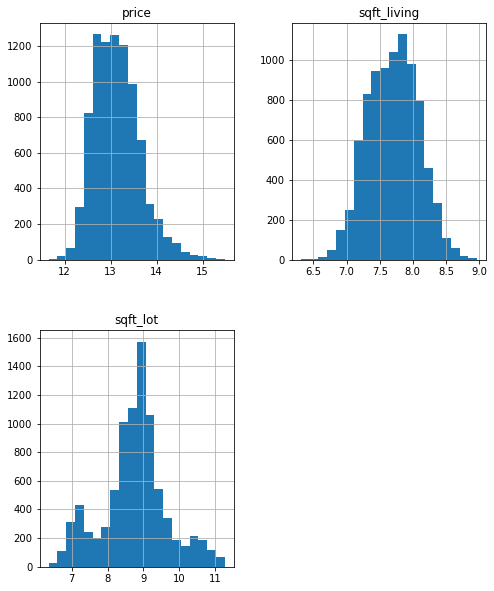

In [671]:

pd.concat([price_fin, pred_fin[['sqft_living','sqft_lot']]], axis=1).hist(figsize=(8,10), bins=20);


In [672]:
# Create OLS linear model


pred_int = sm.add_constant(pred_fin)
model = sm.OLS(price_fin,pred_int).fit()
model.rsquared_adj


0.9192101340304918

In [673]:
coef_df=model.params.reset_index()
coef_df.columns=["Column","Value"]

In [674]:
abs_test_results=[]
test_results=[]
for i in range(4000):
    X=np.array(df[['sqft_living','yr_built','zipcode','grade','waterfront','view', 'sqft_lot','price']].sample())[0]
    sqft_living,year,zipcode,grade,water,view,sqft_lot,price=X

    b0,b1,b2,b3,b4,b5,b6,b7 = get_coeff( year=year, zipcode=zipcode, grade=grade, water=water, view=view, coef_df=coef_df)
    y=round( np.exp(b0 + b1*np.log(sqft_living) + b2 + b3 + b4 + b5 + b6 + b7*np.log(sqft_lot)) )
   
    miss_abs= np.abs(100-(y/price*100))
    miss= 100-(y/price*100)
    test_results.append(miss)
    abs_test_results.append(miss_abs)

avg_miss=sum(test_results)/len(test_results)
avg_miss_abs=sum(abs_test_results)/len(abs_test_results)
print (avg_miss, avg_miss_abs)



-1.1963777187362632 10.57641791261384


In [403]:

def calculate_price (sqft_living, yr_built, zipcode, grade, waterfront, view , sqft_lot, coef_df=coef_df):
    if view == '-':
        view='NONE'

    if waterfront:
        waterfront='WATERFRONT'
    else:
        waterfront='NONE'

    b0,b1,b2,b3,b4,b5,b6,b7 = get_coeff( yr_built,zipcode,grade, waterfront, view, coef_df)
    y=round( np.exp(b0 + b1*np.log(sqft_living) + b2 + b3 + b4 + b5 + b6 + b7*np.log(sqft_lot)) )

    print(y)
    return y,b0,b1,b2,b3,b4,b5,b6,b7



In [404]:
title=form_items[0].children[0]
zipW=form_items[1].children[1]
yearW=form_items[1].children[2]
gradeW=form_items[2].children[1]
livingW=form_items[3].children[1]
lotW=form_items[4].children[1]
viewW=form_items[5].children[1]
waterW=form_items[5].children[2]
#buttonW=form_items[5].children[0]


In [405]:
#def on_button_clicked(X):
#    X=calculate_price(livingW.value, yearW.value, zipW.value,  gradeW.value, waterW.value, viewW.value, lotW.value, 'No')
#    with out:
#        output2.clear_output()
#        display("{:,}".format(X[0]))

#buttonW.on_click(on_button_clicked)  


output = widgets.interactive_output(calculate_price, {
    'zipcode': zipW, 'yr_built':yearW, 'grade':gradeW,
    'sqft_living':livingW,'sqft_lot':lotW,'view':viewW,'waterfront':waterW } )

      
ui = widgets.VBox([form, output])

output.layout={'border': '3px solid green', 'width':'150px'}

display(ui)




In [19]:
df[['sqft_living','yr_built','zipcode','grade','waterfront','view', 'sqft_lot','price']].sample()

X=calculate_price(7550,2000, 98030, 10, 'NO','NONE', 54100);
X

In [314]:
import folium

lat_list=[lat for lat in df.groupby('coord_range').min()['lat']]
long_list=[long for long in df.groupby('coord_range').min()['long']]


In [315]:


base_map = folium.Map([lat[0], long[0]], zoom_start=13)